In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

def visualize_pointcloud_o3d(pts_file, seg_file=None, num_points=5000):
    points = np.loadtxt(pts_file).astype(np.float32)  # (N,3)
    if seg_file:
        labels = np.loadtxt(seg_file).astype(np.int64) # (N,)
    else:
        labels = None

    # randomly sampling points for efficiency
    if num_points < points.shape[0]:
        idx = np.random.choice(points.shape[0], num_points, replace=False)
        points = points[idx]
        if labels is not None:
            labels = labels[idx]

    # transform to open3D object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # visualise label with colors
    if labels is not None:
        max_label = labels.max()
        cmap = plt.get_cmap("tab20")   # 20 color
        colors = cmap(labels / (max_label if max_label > 0 else 1))[:, :3]
        pcd.colors = o3d.utility.Vector3dVector(colors)
    else:
        pcd.paint_uniform_color([0.5, 0.5, 0.5])  # grey

    o3d.visualization.draw_geometries([pcd])

# sample
pts_file = "./train_data/1.pts"
seg_file = "./train_label/1.seg"
visualize_pointcloud_o3d(pts_file, seg_file)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class PointCloudDataset(Dataset):
    def __init__(self, data_dir, label_dir, transform=None, num_points=2048):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.filenames = [f.split('.')[0] for f in os.listdir(data_dir) if f.endswith('.pts')]
        self.transform = transform
        self.num_points = num_points

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]

        # load cloud points
        pts = np.loadtxt(os.path.join(self.data_dir, fname + ".pts"))
        labels = np.loadtxt(os.path.join(self.label_dir, fname + ".seg")).astype(np.int64)
        labels = labels - 1   #  [1,2,3] → [0,1,2]
#         # Debug: 
#         unique_labels = np.unique(labels)
#         print(f"File {fname}: unique labels = {unique_labels}")

        # sampling parts of the points
        if pts.shape[0] >= self.num_points:
            choice = np.random.choice(pts.shape[0], self.num_points, replace=False)
        else:  # points padding
            choice = np.random.choice(pts.shape[0], self.num_points, replace=True)

        pts = pts[choice, :]
        labels = labels[choice]

        if self.transform:
            pts = self.transform(pts)

        return torch.from_numpy(pts).float(), torch.from_numpy(labels).long()


In [3]:
train_dataset = PointCloudDataset("./train_data", "./train_label", num_points=2048)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# 取一个 batch
for pts, labels in train_loader:
    print("pts shape:", pts.shape)       # [x,y,z] (optional [x,y,z,R,G,B])
    print("labels shape:", labels.shape) # label
    break 


pts shape: torch.Size([32, 2048, 3])
labels shape: torch.Size([32, 2048])


In [4]:
from torch import nn

class SimplePointNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.mlp1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp2 = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.mlp3 = nn.Sequential(
            nn.Conv1d(128, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.fc = nn.Conv1d(256, num_classes, 1)

    def forward(self, x):
        # x: [B, N, 3]
        x = x.permute(0, 2, 1)  # [B, 3, N]
        x = self.mlp1(x)
        x = self.mlp2(x)
        x = self.mlp3(x)
        x = self.fc(x)  # [B, num_classes, N]
        return x.permute(0, 2, 1)  # [B, N, num_classes]


In [5]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplePointNet(num_classes=3).to(device)  # 3classes:wall, roof, floor
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    total_loss = 0
    for pts, labels in train_loader:
        pts, labels = pts.to(device), labels.to(device)
        preds = model(pts)  # [B, N, C]
        loss = F.cross_entropy(preds.reshape(-1, preds.shape[-1]), labels.reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 0, Loss: 0.4143
Epoch 1, Loss: 0.3623
Epoch 2, Loss: 0.3510
Epoch 3, Loss: 0.3363
Epoch 4, Loss: 0.3247
Epoch 5, Loss: 0.3136
Epoch 6, Loss: 0.3042
Epoch 7, Loss: 0.3052
Epoch 8, Loss: 0.3000
Epoch 9, Loss: 0.2956
Epoch 10, Loss: 0.2962
Epoch 11, Loss: 0.2892
Epoch 12, Loss: 0.2873
Epoch 13, Loss: 0.2870
Epoch 14, Loss: 0.2940
Epoch 15, Loss: 0.2798
Epoch 16, Loss: 0.2933
Epoch 17, Loss: 0.2839
Epoch 18, Loss: 0.2809
Epoch 19, Loss: 0.2783


Accuracy: 0.9033966064453125


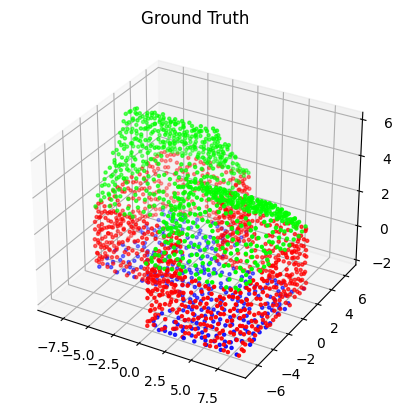

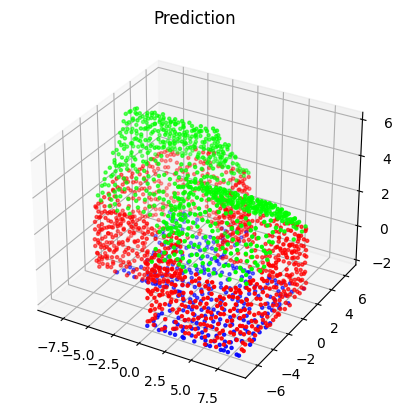

In [6]:
model.eval()
with torch.no_grad():
    for pts, labels in train_loader:  
        pts, labels = pts.to(device), labels.to(device)
        preds = model(pts)  # [B, N, C]
        pred_labels = preds.argmax(dim=-1)  # [B, N]
        break  
correct = (pred_labels == labels).sum().item()
total = labels.numel()
print("Accuracy:", correct / total)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# define color for each class (wall, roof, floor)
colors = np.array([
    [1, 0, 0],  # red
    [0, 1, 0],  # green
    [0, 0, 1],  # blue
])

def visualize_pointcloud(points, labels, title="Point Cloud"):
    points = points.cpu().numpy()
    labels = labels.cpu().numpy()
    c = colors[labels]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:,0], points[:,1], points[:,2], c=c, s=5)
    ax.set_title(title)
    plt.show()

# first sample
idx = 0
visualize_pointcloud(pts[idx], labels[idx], title="Ground Truth")
visualize_pointcloud(pts[idx], pred_labels[idx], title="Prediction")


In [7]:
out = torch.cat([pts[idx], pred_labels[idx].unsqueeze(-1).float()], dim=-1)
np.savetxt("predicted_cloud.pts", out.cpu().numpy(), fmt="%.4f")
